# DS 3001: Voting Project - Michelle Kim and Cara Seely

## Summary
This project looks to analyze voting patterns in Virginia from historical election data, aiming to uncover patterns and predict future outcomes. By looking into data on voting by candidate and party, with geographical information, we seek to explore voter preferences, election results and predict the outcomes of the 2024 election. In this project, we look to answer the question of how election results in Virginia have changed over time and how results will look in future elections. Our project utilizes numerous datasets and csv files, including county, county adjacencies, and voting in Virginia data. These datasets were cleaned before conducting analysis, which is discussed later in this paper. After cleaning, the variables within the data were analyzed through visualizations. The variables being used in this analysis include county FIP codes, total votes, candidates, and political party. These are key variables that will be the most effective in giving insights about voting in Virginia. With the help of these visualizations, our project then aims to predict the election results of Virginia in 2024. Our projected results show that the Democratic party votes will continue to be the highest, but that the Republican party will also have a substantial amount of votes.

## Data
This part of the paper is dedicated to explaining the data and key variables of the analysis, including the data cleaning that was conducted in this project. Data cleaning is an essential first step in data analysis and helped to ensure that our datasets were consistent. Before cleaning, we imported necessary libraries and read in the csv files. Our datasets primarily consist of historical voting data for Virginia. Key variables include, ‘year,’ ‘county name’, ‘candidate’, ‘party’, ‘candidate votes’, and ‘total votes,’ which provide information about electoral trends over the years.

In [1]:
! git clone https://github.com/michellehkim280/project_voting

fatal: destination path 'project_voting' already exists and is not an empty directory.


In [2]:
pip install --upgrade numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importing Packages
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
import zipfile
import os

# Loading Data
vdf = pd.read_csv('project_voting/data/voting_VA.csv') # Load historical voting data
cdf = pd.read_csv('project_voting/data/county_adjacencies.csv') # Load county adjacency data and population data

/Users/michellekim/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/michellekim/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [4]:
print(vdf)

      Unnamed: 0  year     state state_po      county_name  county_fips  \
0          11161  2000  VIRGINIA       VA         ACCOMACK        51001   
1          11162  2000  VIRGINIA       VA         ACCOMACK        51001   
2          11163  2000  VIRGINIA       VA         ACCOMACK        51001   
3          11164  2000  VIRGINIA       VA         ACCOMACK        51001   
4          11165  2000  VIRGINIA       VA        ALBEMARLE        51003   
...          ...   ...       ...      ...              ...          ...   
3731       71966  2020  VIRGINIA       VA  WINCHESTER CITY        51840   
3732       71967  2020  VIRGINIA       VA  WINCHESTER CITY        51840   
3733       71968  2020  VIRGINIA       VA  WINCHESTER CITY        51840   
3734       71969  2020  VIRGINIA       VA  WINCHESTER CITY        51840   
3735       71970  2020  VIRGINIA       VA  WINCHESTER CITY        51840   

            office       candidate       party  candidatevotes  totalvotes  \
0     US PRESIDENT   

Reading the numerous county_data csv files was troubling because we had to conduct the same loading and cleaning for each, and figure out how to save it all to one dataframe. We used a for loop that iterates over our list of files and stores them all in one array. After loading in the multiple csv files, we cleaned them by first standardizing the FIPS codes. This ensures that any column named ‘FIPS’ or ‘county_fips’ contains a string that is 5 characters, giving us consistency across data sets. An always significant challenge with any project involving data is dealing with missing values and outliers that could potentially skew the analysis. For this dataset, we decided to fill in missing values with the median of the column. We went through this strategy to maintain the integrity of the dataset, rather than entirely removing it. Removing entire rows with missing values could result in losing potentially good data and reduce the power of our statistical analysis. Our approach was also similarly done with categorical columns, as we fill in missing values with the most of each column. However, we removed any rows that are missing the FIPS code because it is critical in identifying counties or states. Without the FIPS code, our geographical data would be incomplete.

In [5]:
# Loading and Cleaning county_data

def load_data(file_path):
    return pd.read_csv(file_path, encoding='ISO-8859-1')

def prepare_data(df):
    # Standardize FIPS codes
    fips_columns = [col for col in ['FIPS', 'county_fips'] if col in df.columns]
    for col in fips_columns:
        df[col] = df[col].astype(str).str.zfill(5)

    # Remove unnecessary columns
    columns_to_drop = [col for col in ['Unneeded1', 'Unneeded2'] if col in df.columns]
    df.drop(columns=columns_to_drop, inplace=True)

    # Fill numeric columns with the median
    for col in df.select_dtypes(include='number').columns:
        df[col].fillna(df[col].median(), inplace=True)

    # Fill categorical columns with the mode (most frequent value)
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].astype(str)
        if not df[col].mode().empty:
            df[col].fillna(df[col].mode()[0], inplace=True)

    # Remove rows with missing FIPS codes if critical
    df.dropna(subset=fips_columns, inplace=True)

    # Remove duplicates
    df.drop_duplicates(inplace=True)

    return df

# Directory to save cleaned files
output_directory = 'project_voting/data/county_data/cleaned'
os.makedirs(output_directory, exist_ok=True)

# Paths to the county data files
files = [
    'project_voting/data/county_data/0002_ds176_20105_county_E.csv',
    'project_voting/data/county_data/0002_ds177_20105_county_E.csv',
    'project_voting/data/county_data/0002_ds191_20125_county_E.csv',
    'project_voting/data/county_data/0002_ds206_20145_county_E.csv',
    'project_voting/data/county_data/0002_ds225_20165_county_E.csv',
    'project_voting/data/county_data/0002_ds239_20185_county_E.csv',
    'project_voting/data/county_data/0002_ds249_20205_county_E.csv',
    'project_voting/data/county_data/0002_ds250_20205_county_E.csv'
]

# Load, clean, and save each file
for file_path in files:
    df = load_data(file_path)
    cleaned_df = prepare_data(df)
    cleaned_file_path = os.path.join(output_directory, os.path.basename(file_path).replace('.csv', '_cleaned.csv'))
    cleaned_df.to_csv(cleaned_file_path, index=False)


/var/folders/r7/8yfx5p116t50w33dph81nh4c0000gn/T/ipykernel_66235/3430997038.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/var/folders/r7/8yfx5p116t50w33dph81nh4c0000gn/T/ipykernel_66235/3430997038.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

For the voting_va csv file, we once again standardized the FIPS codes, in addition to certain columns. We choose to remove rows that were missing critical information in columns like ‘county_fips’, ‘candidatevotes’, or ‘totalvotes’ because these values are essential for analyzing voting patterns and outcomes. Changing the all-capitalization of certain columns were changed to lowercase, in order to ease the process of voting. Overall, all of these cleaning steps were necessary to ensure that our data quality is consistent and reliable, enabling us to create better insights.

In [6]:
# Cleaning vdf (historical voting data)
# Standardize FIPS codes to ensure they are five characters long, zero-padded
vdf['county_fips'] = vdf['county_fips'].astype(str).str.zfill(5)

# Remove any rows where critical information is missing
vdf.dropna(subset=['county_fips', 'candidatevotes', 'totalvotes'], inplace=True)

# Convert vote counts to integers (in case they are not)
vdf['candidatevotes'] = vdf['candidatevotes'].astype(int)
vdf['totalvotes'] = vdf['totalvotes'].astype(int)

# Check for any duplicates and remove them
vdf.drop_duplicates(inplace=True)

# Convert certain columns with usable data to lower case for ease
vdf['county_name'] = vdf['county_name'].str.lower()
vdf['candidate'] = vdf['candidate'].str.lower()
vdf['party'] = vdf['party'].str.lower()

In [7]:
vb_years = vdf[vdf['county_name'].str.lower() == "virginia beach".lower()][['year', 'candidate', 'party', 'candidatevotes']]
print(vb_years)

      year        candidate       party  candidatevotes
520   2000          al gore    democrat           62268
521   2000   george w. bush  republican           83674
522   2000      ralph nader       green            2370
523   2000            other       other            1459
926   2004       john kerry    democrat           70666
927   2004   george w. bush  republican          103752
928   2004            other       other            1269
1328  2008     barack obama    democrat           98885
1329  2008      john mccain  republican          100319
1330  2008            other       other            2045
1730  2012     barack obama    democrat           94299
1731  2012      mitt romney  republican           99291
1732  2012            other       other            3051
2132  2016  hillary clinton    democrat           91032
2133  2016     donald trump  republican           98224
2134  2016            other       other           14006


In [8]:
new_rows = pd.DataFrame({
    'year': [2020, 2020],
    'candidate': ['joseph r Biden jr', 'Donald j trump'],
    'party': ['democrat', 'republican'],
    'candidatevotes': [117393, 105087]
})

vb = pd.concat([vb_years, new_rows], ignore_index=True)
vb['candidate'] = vb['candidate'].str.lower()
print(vb)

    year          candidate       party  candidatevotes
0   2000            al gore    democrat           62268
1   2000     george w. bush  republican           83674
2   2000        ralph nader       green            2370
3   2000              other       other            1459
4   2004         john kerry    democrat           70666
5   2004     george w. bush  republican          103752
6   2004              other       other            1269
7   2008       barack obama    democrat           98885
8   2008        john mccain  republican          100319
9   2008              other       other            2045
10  2012       barack obama    democrat           94299
11  2012        mitt romney  republican           99291
12  2012              other       other            3051
13  2016    hillary clinton    democrat           91032
14  2016       donald trump  republican           98224
15  2016              other       other           14006
16  2020  joseph r biden jr    democrat         

In [9]:
print(cdf)

               County  Population2022   FIPS  District                   N1  \
0            Accomack           33191  51001         2       Northumberland   
1           Albemarle          114534  51003         5  CharlottesvilleCity   
2      AlexandriaCity          155525  51510         8              Fairfax   
3           Alleghany           14835  51005         6                Craig   
4              Amelia           13455  51007         5         PrinceEdward   
..                ...             ...    ...       ...                  ...   
128    WinchesterCity           27936  51840         6            Frederick   
129              Wise           35421  51195         9                  Lee   
130             Wythe           28111  51197         9                Bland   
131              York           71341  51199         1           Gloucester   
132  WilliamsburgCity           15920  51830         1             JamesCty   

             N2                N3               N4 

In [10]:
print(vdf)
vb_years = vdf[vdf['county_name'] == "virginia beach"]['year']
print("Years associated with Virginia Beach:")
print(vb_years)

      Unnamed: 0  year     state state_po      county_name county_fips  \
0          11161  2000  VIRGINIA       VA         accomack       51001   
1          11162  2000  VIRGINIA       VA         accomack       51001   
2          11163  2000  VIRGINIA       VA         accomack       51001   
3          11164  2000  VIRGINIA       VA         accomack       51001   
4          11165  2000  VIRGINIA       VA        albemarle       51003   
...          ...   ...       ...      ...              ...         ...   
3731       71966  2020  VIRGINIA       VA  winchester city       51840   
3732       71967  2020  VIRGINIA       VA  winchester city       51840   
3733       71968  2020  VIRGINIA       VA  winchester city       51840   
3734       71969  2020  VIRGINIA       VA  winchester city       51840   
3735       71970  2020  VIRGINIA       VA  winchester city       51840   

            office       candidate       party  candidatevotes  totalvotes  \
0     US PRESIDENT         al gor

In [11]:
print(df)

      Unnamed: 0              GISJOIN            YEAR  \
0              1  GIS Join Match Code  Data File Year   
1              2             G0100010       2016-2020   
2              3             G0100030       2016-2020   
3              4             G0100050       2016-2020   
4              5             G0100070       2016-2020   
...          ...                  ...             ...   
3217        3218             G7201450       2016-2020   
3218        3219             G7201470       2016-2020   
3219        3220             G7201490       2016-2020   
3220        3221             G7201510       2016-2020   
3221        3222             G7201530       2016-2020   

                         STUSAB      REGIONA      DIVISIONA        STATE  \
0     State Postal Abbreviation  Region Code  Division Code   State Name   
1                            AL          nan            nan      Alabama   
2                            AL          nan            nan      Alabama   
3          

In [12]:
cdf['FIPS'] = cdf['FIPS'].astype(str)
df = pd.merge(vdf, cdf, left_on='county_fips', right_on='FIPS', how='inner')
print(df)

      Unnamed: 0  year     state state_po      county_name county_fips  \
0          11161  2000  VIRGINIA       VA         accomack       51001   
1          11162  2000  VIRGINIA       VA         accomack       51001   
2          11163  2000  VIRGINIA       VA         accomack       51001   
3          11164  2000  VIRGINIA       VA         accomack       51001   
4          11165  2000  VIRGINIA       VA        albemarle       51003   
...          ...   ...       ...      ...              ...         ...   
3715       71966  2020  VIRGINIA       VA  winchester city       51840   
3716       71967  2020  VIRGINIA       VA  winchester city       51840   
3717       71968  2020  VIRGINIA       VA  winchester city       51840   
3718       71969  2020  VIRGINIA       VA  winchester city       51840   
3719       71970  2020  VIRGINIA       VA  winchester city       51840   

            office       candidate       party  candidatevotes  ...  \
0     US PRESIDENT         al gore    de

## Results
Before making any predictions, we wanted to first analyze historical data and gain an understanding of voting in Virginia. We began by creating bar graphs displaying the total candidate votes for presidential candidates in the United States from each election in 2000-2020. To create the graphs, we selected only relevant columns from the voting_va dataframe (vdf) and filtered the data frame for the election year, ensuring that the analysis only focuses on that one election cycle. The code then aggregates the total votes for each candidate using ‘groupby’ on the column, ‘candidate’ and then adding up ‘candiddatevotes.’ This gives us the total votes for each candidate that they received in the designated election from Virginia. We used specific colors for different parties, so red for the Republican Party, blue for the Democratic Party, etc. This was to give a visual distinction between candidates and to allow for better comprehension of the graph.  




In [13]:
vdf_filtered = vdf[['candidate', 'party', 'candidatevotes', 'year', 'county_name']]

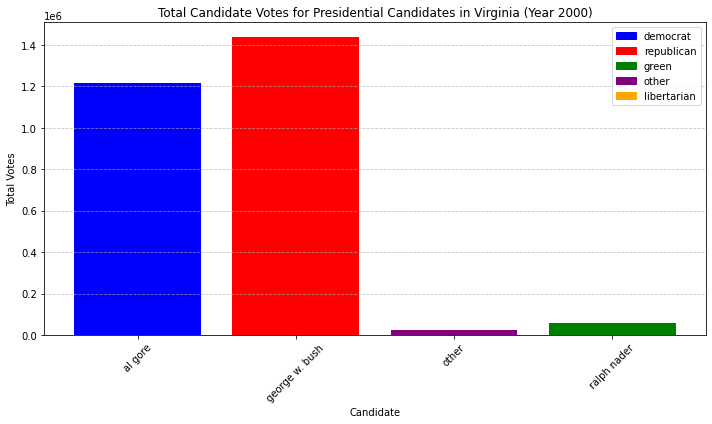

In [14]:
# 2000: Filter the DataFrame for the election year
vdf_2000 = vdf_filtered[vdf_filtered['year'] == 2000]
total_candidate_votes = vdf_2000.groupby('candidate')['candidatevotes'].sum()
#print(total_candidate_votes)
#print(vdf_2000)

color_map = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}

plt.figure(figsize=(10, 6))
for candidate, votes in total_candidate_votes.items():
    party_color = color_map[vdf[vdf['candidate'] == candidate]['party'].iloc[0]]
    plt.bar(candidate, votes, color=party_color)
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_labels, color_map.keys(), loc='upper right')
plt.title('Total Candidate Votes for Presidential Candidates in Virginia (Year 2000)')
plt.xlabel('Candidate')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The bar graph above illustrates the total candidate votes for presidential candidates in Virginia for the year 2000. It vividly highlights the dominance of the two major parties, with Al Gore of the Democrats and George W. Bush of the Republicans capturing the vast majority of votes. The republican candidate only slightly had more votes compared to the democrat.

In [15]:
# Assuming 'vdf_filtered' contains the entire dataset with all years and counties
# Filter the DataFrame for the election year 2000
vdf_2000 = vdf_filtered[vdf_filtered['year'] == 2000]

# Summing up votes per candidate
total_candidate_votes = vdf_2000.groupby('candidate')['candidatevotes'].sum()

# Create a mapping of candidate to party from the year 2000 data
candidate_to_party = vdf_2000.drop_duplicates(subset='candidate').set_index('candidate')['party'].to_dict()

# Create a DataFrame from the total_candidate_votes Series
table_df = pd.DataFrame(total_candidate_votes).reset_index()
table_df.rename(columns={'candidatevotes': 'Total Votes'}, inplace=True)

# Add a 'Party' column to the table DataFrame
table_df['Party'] = table_df['candidate'].map(candidate_to_party)

# Display the table
print(table_df)

        candidate  Total Votes       Party
0         al gore      1216422    democrat
1  george w. bush      1436877  republican
2           other        25243       other
3     ralph nader        59373       green


We also feel it's important to further analyze the data in tables because they condense complex data into an format that is easy to read and understand. We can see that Bush only won by 200,000 votes, further showing that he did not win by a substantial amount. This shows the numerical contrast to support the visual contrast that we see in the graph.

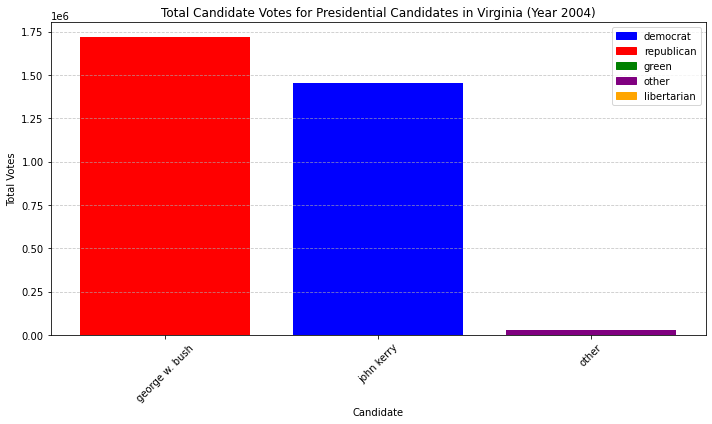

In [16]:
# 2004: Filter the DataFrame for the election year
vdf_2004 = vdf_filtered[vdf_filtered['year'] == 2004]
total_candidate_votes = vdf_2004.groupby('candidate')['candidatevotes'].sum()

color_map = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}

plt.figure(figsize=(10, 6))
for candidate, votes in total_candidate_votes.items():
    party_color = color_map[vdf[vdf['candidate'] == candidate]['party'].iloc[0]]
    plt.bar(candidate, votes, color=party_color)
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_labels, color_map.keys(), loc='upper right')
plt.title('Total Candidate Votes for Presidential Candidates in Virginia (Year 2004)')
plt.xlabel('Candidate')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:
# Assuming 'vdf_filtered' contains the entire dataset with all years and counties
# Filter the DataFrame for the election year 2004
vdf_2004 = vdf_filtered[vdf_filtered['year'] == 2004]

# Summing up votes per candidate
total_candidate_votes = vdf_2004.groupby('candidate')['candidatevotes'].sum()

# Create a mapping of candidate to party from the year 2004 data
candidate_to_party = vdf_2004.drop_duplicates(subset='candidate').set_index('candidate')['party'].to_dict()

# Create a DataFrame from the total_candidate_votes Series
table_df = pd.DataFrame(total_candidate_votes).reset_index()
table_df.rename(columns={'candidatevotes': 'Total Votes'}, inplace=True)

# Add a 'Party' column to the table DataFrame
table_df['Party'] = table_df['candidate'].map(candidate_to_party)

# Display the table
print(table_df)

        candidate  Total Votes       Party
0  george w. bush      1716959  republican
1      john kerry      1454742    democrat
2           other        26666       other


Once again, this table and graph shows an increase in total voters. George W. Bush receives a record number of votes for any party. There is less votes for a candidate classified as "other" than the previous election as well.

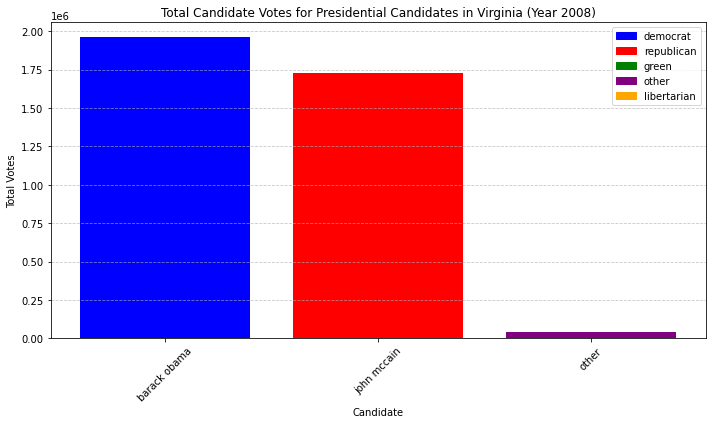

In [18]:
# 2008: Filter the DataFrame for the election year
vdf_2008 = vdf_filtered[vdf_filtered['year'] == 2008]
total_candidate_votes = vdf_2008.groupby('candidate')['candidatevotes'].sum()

color_map = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}

plt.figure(figsize=(10, 6))
for candidate, votes in total_candidate_votes.items():
    party_color = color_map[vdf[vdf['candidate'] == candidate]['party'].iloc[0]]
    plt.bar(candidate, votes, color=party_color)
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_labels, color_map.keys(), loc='upper right')
plt.title('Total Candidate Votes for Presidential Candidates in Virginia (Year 2008)')
plt.xlabel('Candidate')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This is the first graph of our project where the Democratic Party recieved the most votes. The graph clearly demonstrates that the vast majority of votes were once again taken by the two major parties: Democrats and Republicans. Barack Obama (Democrat) and John McCain (Republican) received almost all of the votes, with Obama leading significantly in Virginia. Barack Obama’s lead over John McCain is visually significant. This might potentially reflect broader national trends or specific local factors that led more voters towards Obama.

In [19]:
# Assuming 'vdf_filtered' contains the entire dataset with all years and counties
# Filter the DataFrame for the election year 2008
vdf_2008 = vdf_filtered[vdf_filtered['year'] == 2008]

# Summing up votes per candidate
total_candidate_votes = vdf_2008.groupby('candidate')['candidatevotes'].sum()

# Create a mapping of candidate to party from the year 2008 data
candidate_to_party = vdf_2008.drop_duplicates(subset='candidate').set_index('candidate')['party'].to_dict()

# Create a DataFrame from the total_candidate_votes Series
table_df = pd.DataFrame(total_candidate_votes).reset_index()
table_df.rename(columns={'candidatevotes': 'Total Votes'}, inplace=True)

# Add a 'Party' column to the table DataFrame
table_df['Party'] = table_df['candidate'].map(candidate_to_party)

# Display the table
print(table_df)

      candidate  Total Votes       Party
0  barack obama      1959532    democrat
1   john mccain      1725005  republican
2         other        38723       other


This table shows Obama's quite decisive win and a large margin between his total votes with McCain's. In addition, this table goes to shows the highest voter turnout than ever before. There is an increase in votes for candidates classified as "other".

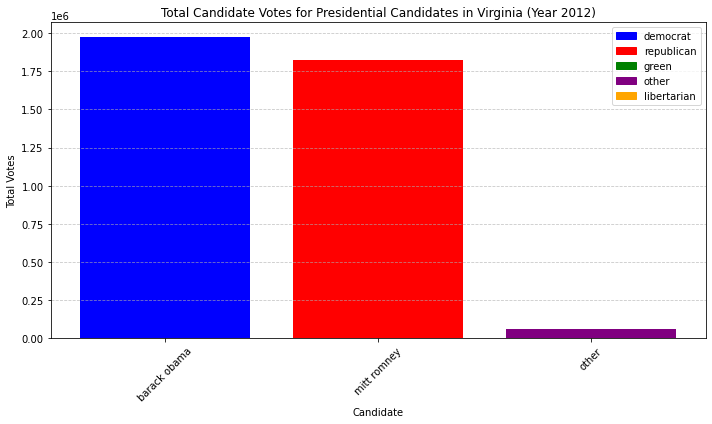

In [20]:
# 2012: Filter the DataFrame for the election year
vdf_2012 = vdf_filtered[vdf_filtered['year'] == 2012]
total_candidate_votes = vdf_2012.groupby('candidate')['candidatevotes'].sum()

color_map = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}

plt.figure(figsize=(10, 6))
for candidate, votes in total_candidate_votes.items():
    party_color = color_map[vdf[vdf['candidate'] == candidate]['party'].iloc[0]]
    plt.bar(candidate, votes, color=party_color)
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_labels, color_map.keys(), loc='upper right')
plt.title('Total Candidate Votes for Presidential Candidates in Virginia (Year 2012)')
plt.xlabel('Candidate')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [21]:
# Assuming 'vdf_filtered' contains the entire dataset with all years and counties
# Filter the DataFrame for the election year 2012
vdf_2012 = vdf_filtered[vdf_filtered['year'] == 2012]

# Summing up votes per candidate
total_candidate_votes = vdf_2012.groupby('candidate')['candidatevotes'].sum()

# Create a mapping of candidate to party from the year 2012 data
candidate_to_party = vdf_2012.drop_duplicates(subset='candidate').set_index('candidate')['party'].to_dict()

# Create a DataFrame from the total_candidate_votes Series
table_df = pd.DataFrame(total_candidate_votes).reset_index()
table_df.rename(columns={'candidatevotes': 'Total Votes'}, inplace=True)

# Add a 'Party' column to the table DataFrame
table_df['Party'] = table_df['candidate'].map(candidate_to_party)

# Display the table
print(table_df)

      candidate  Total Votes       Party
0  barack obama      1971820    democrat
1   mitt romney      1822522  republican
2         other        60147       other


This shows, yet again, how decisive Obama's win was against the republican candidate. Candidates categorized as "other" increases to a record high.

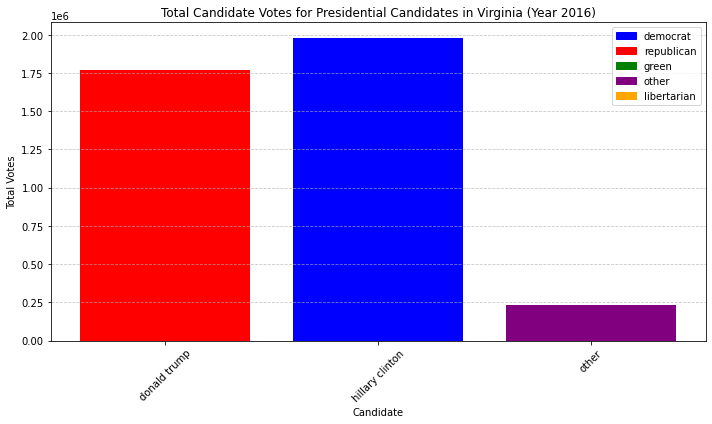

In [22]:
# 2016: Filter the DataFrame for the election year
vdf_2016 = vdf_filtered[vdf_filtered['year'] == 2016]
total_candidate_votes = vdf_2016.groupby('candidate')['candidatevotes'].sum()

color_map = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}

plt.figure(figsize=(10, 6))
for candidate, votes in total_candidate_votes.items():
    party_color = color_map[vdf[vdf['candidate'] == candidate]['party'].iloc[0]]
    plt.bar(candidate, votes, color=party_color)
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_labels, color_map.keys(), loc='upper right')
plt.title('Total Candidate Votes for Presidential Candidates in Virginia (Year 2016)')
plt.xlabel('Candidate')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
# Assuming 'vdf_filtered' contains the entire dataset with all years and counties
# Filter the DataFrame for the election year 2016
vdf_2016 = vdf_filtered[vdf_filtered['year'] == 2016]

# Summing up votes per candidate
total_candidate_votes = vdf_2016.groupby('candidate')['candidatevotes'].sum()

# Create a mapping of candidate to party from the year 2016 data
candidate_to_party = vdf_2016.drop_duplicates(subset='candidate').set_index('candidate')['party'].to_dict()

# Create a DataFrame from the total_candidate_votes Series
table_df = pd.DataFrame(total_candidate_votes).reset_index()
table_df.rename(columns={'candidatevotes': 'Total Votes'}, inplace=True)

# Add a 'Party' column to the table DataFrame
table_df['Party'] = table_df['candidate'].map(candidate_to_party)

# Display the table
print(table_df)

         candidate  Total Votes       Party
0     donald trump      1769443  republican
1  hillary clinton      1981473    democrat
2            other       233715       other


This graph and table are particularly more interesting given that Hillary Clinton received more votes than Donald Trump despite Trump's national victory. This shows the significance of the Electoral College system in U.S. elections, where a candidate can win the presidency without getting the majority of the popular vote. This election goes to show that Virginia is a swing state, making it critical in the national election outcomes. Candidates classified as "other" reaches previously unreached digits!

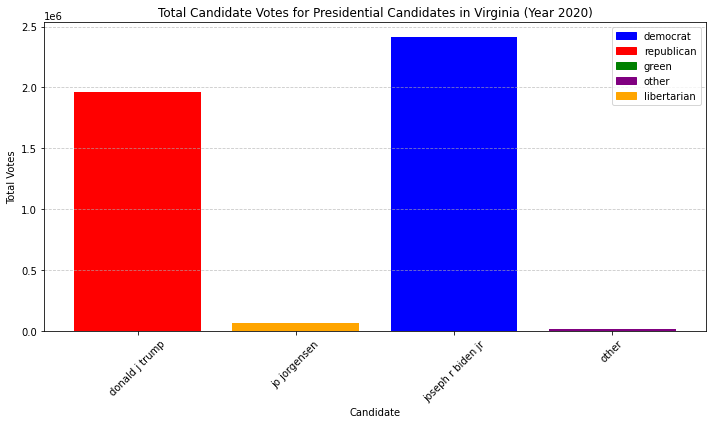

In [24]:
# 2020: Filter the DataFrame for the election year
vdf_2020 = vdf_filtered[vdf_filtered['year'] == 2020]
total_candidate_votes = vdf_2020.groupby('candidate')['candidatevotes'].sum()

color_map = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}

plt.figure(figsize=(10, 6))
for candidate, votes in total_candidate_votes.items():
    party_color = color_map[vdf[vdf['candidate'] == candidate]['party'].iloc[0]]
    plt.bar(candidate, votes, color=party_color)
legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_labels, color_map.keys(), loc='upper right')
plt.title('Total Candidate Votes for Presidential Candidates in Virginia (Year 2020)')
plt.xlabel('Candidate')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [25]:
# Assuming 'vdf_filtered' contains the entire dataset with all years and counties
# Filter the DataFrame for the election year 2020
vdf_2020 = vdf_filtered[vdf_filtered['year'] == 2020]

# Summing up votes per candidate
total_candidate_votes = vdf_2020.groupby('candidate')['candidatevotes'].sum()

# Create a mapping of candidate to party from the year 2020 data
candidate_to_party = vdf_2020.drop_duplicates(subset='candidate').set_index('candidate')['party'].to_dict()

# Create a DataFrame from the total_candidate_votes Series
table_df = pd.DataFrame(total_candidate_votes).reset_index()
table_df.rename(columns={'candidatevotes': 'Total Votes'}, inplace=True)

# Add a 'Party' column to the table DataFrame
table_df['Party'] = table_df['candidate'].map(candidate_to_party)

# Display the table
print(table_df)

           candidate  Total Votes        Party
0     donald j trump      1962430   republican
1       jo jorgensen        64761  libertarian
2  joseph r biden jr      2413568     democrat
3              other        21841        other


This the last election for which we have data for, and plays a key role in the predicition of the 2024 election outcome for Virginia voters. The changes in parties is of the most notable. Although smaller in total votes than democrats and republicans, libertarian is an important category. Candidates classified as "other" significantly decreases, as total Virginia votes reaches yet another all time high! This shows that while the Virginia population grows, people are also more likely to vote, potentially exemplifying the increasing importance of political actions.

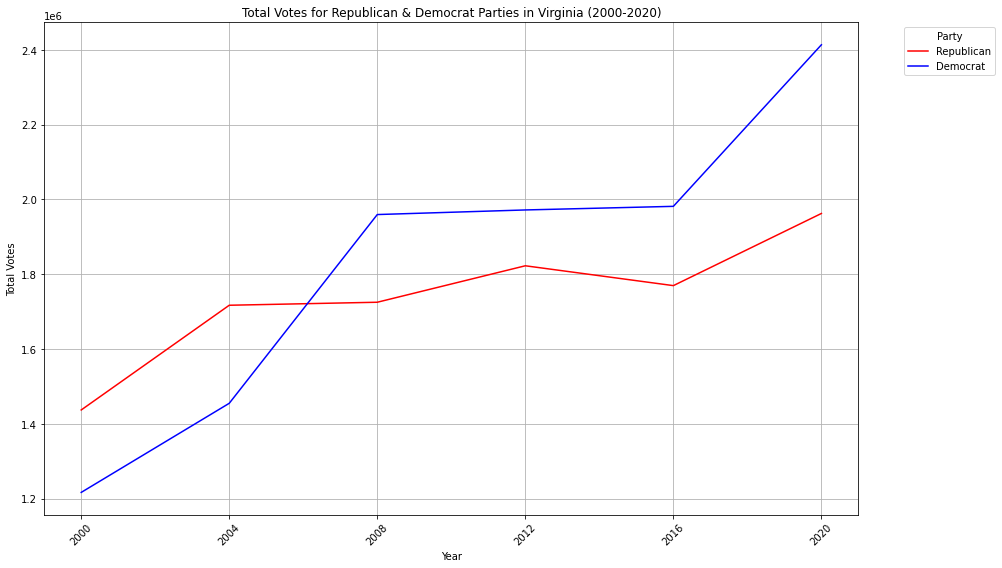

In [26]:
# Filter for only Republican and Democratic parties
total_votes_over_time = vdf_filtered[
    vdf_filtered['party'].isin(['republican', 'democrat'])
].groupby(['year', 'party'])['candidatevotes'].sum().reset_index()

# Prepare the plot
plt.figure(figsize=(14, 8))

# Color map for Republican and Democrat
color_map = {
    'democrat': 'blue',
    'republican': 'red'
}

# Plot each party's vote trajectory
for party in ['republican', 'democrat']:
    party_data = total_votes_over_time[total_votes_over_time['party'] == party]
    plt.plot(party_data['year'], party_data['candidatevotes'], label=party.capitalize(), color=color_map[party])

# Adding labels and legend
plt.title('Total Votes for Republican & Democrat Parties in Virginia (2000-2020)')
plt.xlabel('Year')
plt.ylabel('Total Votes')
plt.xticks(total_votes_over_time['year'].unique(), rotation=45)  # Ensure all years are shown
plt.grid(True)
plt.legend(title='Party', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()

# Show the plot
plt.show()


This figure of total votes for republican and democratic parties over time gives great intell to the change in majority votes. Republican votes and democratic votes both increase in time, but Republican votes don't increase as significantly. In the first election year for which we have data, there is about a 0.2*10^6 difference between democratic voters and the leading republican party. Between the 2004 and 2008 elections, democratic voters took the lead over Republicans and have held it since. This is why Virginia is classified as a swing state - it can be a close call between majority voters. However, there is an increasing desparity between the number of voters for the parties, signifying Virginia's increasing likeliness to become a "blue" state.

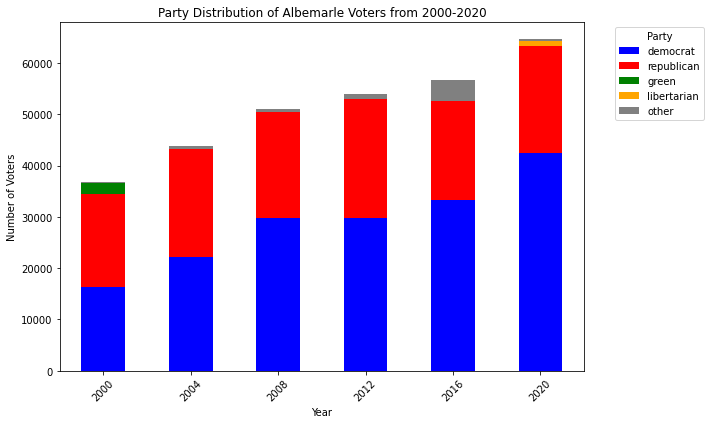

In [35]:
# Albemarle voting 2000-2020 (us!)
party_colors = {
    'democrat': 'blue', 
    'republican': 'red', 
    'green': 'green', 
    'libertarian': 'orange', 
    'other': 'grey'
}

albemarledf = vdf_filtered[(vdf_filtered['county_name'] == 'albemarle') & (vdf_filtered['year'].isin(range(2000,2024)))]
pivot_df = albemarledf.pivot_table(index='year', columns='party', values='candidatevotes', aggfunc='sum', fill_value=0)

column_order = ['democrat', 'republican', 'green', 'libertarian', 'other']
pivot_df = pivot_df.reindex(columns=column_order)

pivot_df.plot(kind='bar', stacked=True, color=party_colors.values(), figsize=(10, 6))

plt.title('Party Distribution of Albemarle Voters from 2000-2020')
plt.xlabel('Year')
plt.ylabel('Number of Voters')
plt.xticks(rotation=45)
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

To understand the Albemarle county, democratic votes have been on the rise (despite the little change between 2008 and 2012), while republican voters have been decreasing.

/var/folders/r7/8yfx5p116t50w33dph81nh4c0000gn/T/ipykernel_66235/701391385.py:11: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=albemarledf, x='year', y='candidatevotes', hue="party", palette=party_colors, fill=True)


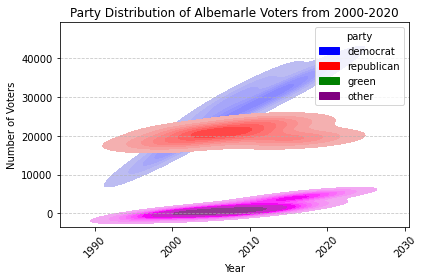

In [28]:
# Showing party distribution of Albemarle voters over time
albemarledf = vdf_filtered[(vdf_filtered['county_name'] == 'albemarle') & (vdf_filtered['year'].isin(range(2000,2020)))]

party_colors = {
    'democrat': 'blue',
    'republican': 'red',
    'green': 'green',
    'other': 'purple',
    'libertarian': 'orange'
}
sns.kdeplot(data=albemarledf, x='year', y='candidatevotes', hue="party", palette=party_colors, fill=True)
plt.title('Party Distribution of Albemarle Voters from 2000-2020')
plt.xlabel("Year")
plt.ylabel("Number of Voters")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This is another visualization of party distribution over time using a kernel density plot. Democratic votes show the steepest slope.:

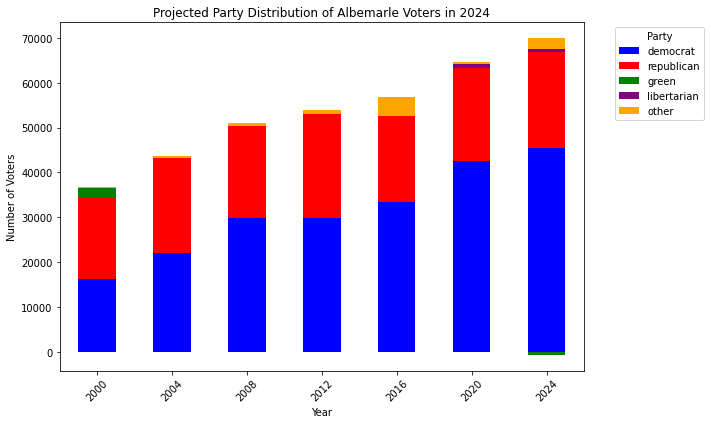

In [29]:
#Predicting 2024 voting outcome for Albemarle county
column_order = ['democrat', 'republican', 'green', 'libertarian', 'other']
pivot_df = pivot_df.reindex(columns=column_order)

predictions = {}
for party in pivot_df.columns:
    X = pivot_df.index.values.reshape(-1, 1)
    y = pivot_df[party].values.reshape(-1, 1)

    if np.isnan(y).any():
        print(f"Warning: Missing values detected for party '{party}'. Skipping prediction.")
        continue

    model = LinearRegression()
    model.fit(X, y)
    predictions[party] = model.predict([[2024]])[0][0]

prediction_df = pd.DataFrame(predictions, index=[2024])

pivot_df_with_predictions = pd.concat([pivot_df, prediction_df])

pivot_df_with_predictions.plot(kind='bar', stacked=True, color=list(party_colors.values()) + ['pink'], figsize=(10, 6))

plt.title('Projected Party Distribution of Albemarle Voters in 2024')
plt.xlabel('Year')
plt.ylabel('Number of Voters')
plt.xticks(rotation=45)
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

The prediction of party distribution for the 2024 presidential election in Albemarle includes an increase in democratic votes, while the Republican party experiences little chane in votes. The statistics also predict that there will be an increase in the number of votes for candidates classified as "other".

In [30]:
# Find the county with the largest increase in democratic voters
democratic_votes = df[df['party'] == 'democrat']

democratic_votes = democratic_votes.groupby('county_name').agg(
    democratic_votes_2000=('candidatevotes', lambda x: x[df['year'] == 2000].sum()),
    democratic_votes_2020=('candidatevotes', lambda x: x[df['year'] == 2020].sum())
)

democratic_votes['increase'] = democratic_votes['democratic_votes_2020'] - democratic_votes['democratic_votes_2000']

county_with_largest_increase = democratic_votes['increase'].idxmax()
largest_increase = democratic_votes.loc[county_with_largest_increase, 'increase']

print(f"The county with the largest increase in Democratic votes from 2000 to 2020 is {county_with_largest_increase} with an increase of {largest_increase} votes.")

The county with the largest increase in Democratic votes from 2000 to 2020 is fairfax with an increase of 219081 votes.


In [31]:
# Find the county with the lowest rate of change or a decrease in democratic voters
democratic_votes['change'] = democratic_votes['democratic_votes_2020'] - democratic_votes['democratic_votes_2000']

county_with_lowest_change = democratic_votes['change'].idxmin()
lowest_change = democratic_votes.loc[county_with_lowest_change, 'change']

print(f"The county with the lowest rate of change or a decrease in Democratic votes from 2000 to 2020 is {county_with_lowest_change} with a change of {lowest_change} votes.")

The county with the lowest rate of change or a decrease in Democratic votes from 2000 to 2020 is virginia beach with a change of -62268 votes.


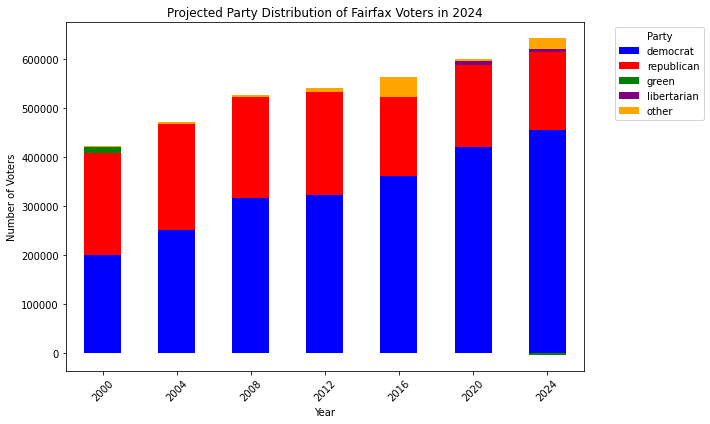

In [32]:
# Predicting 2024 voting outcome for Fairfax county
fairfaxdf = vdf_filtered[(vdf_filtered['county_name'] == 'fairfax') & (vdf_filtered['year'].isin(range(2000,2024)))]
pivot_df = fairfaxdf.pivot_table(index='year', columns='party', values='candidatevotes', aggfunc='sum', fill_value=0)

column_order = ['democrat', 'republican', 'green', 'libertarian', 'other']
pivot_df = pivot_df.reindex(columns=column_order)

predictions = {}
for party in pivot_df.columns:
    X = pivot_df.index.values.reshape(-1, 1)
    y = pivot_df[party].values.reshape(-1, 1)

    if np.isnan(y).any():
        print(f"Warning: Missing values detected for party '{party}'. Skipping prediction.")
        continue

    model = LinearRegression()
    model.fit(X, y)
    predictions[party] = model.predict([[2024]])[0][0]

prediction_df = pd.DataFrame(predictions, index=[2024])

pivot_df_with_predictions = pd.concat([pivot_df, prediction_df])

pivot_df_with_predictions.plot(kind='bar', stacked=True, color=list(party_colors.values()) + ['pink'], figsize=(10, 6))

plt.title('Projected Party Distribution of Fairfax Voters in 2024')
plt.xlabel('Year')
plt.ylabel('Number of Voters')
plt.xticks(rotation=45)
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Fairfax is the county with the greatest increase in democratic voters. In 2016, the Republican party recieved a decreased numbver of votes, while democratic voters increased. The democratic candidate recieved an increase in the number of votes in 2020 as well, and is thus predicted to grow in these votes for the 2024 presidential election.

In [34]:
vb_years = df[df['county_name'] == "virginia beach"]['year']
print("Years associated with Virginia Beach:")
print(vb_years)

Years associated with Virginia Beach:
516     2000
517     2000
518     2000
519     2000
919     2004
920     2004
921     2004
1318    2008
1319    2008
1320    2008
1717    2012
1718    2012
1719    2012
2116    2016
2117    2016
2118    2016
Name: year, dtype: int64


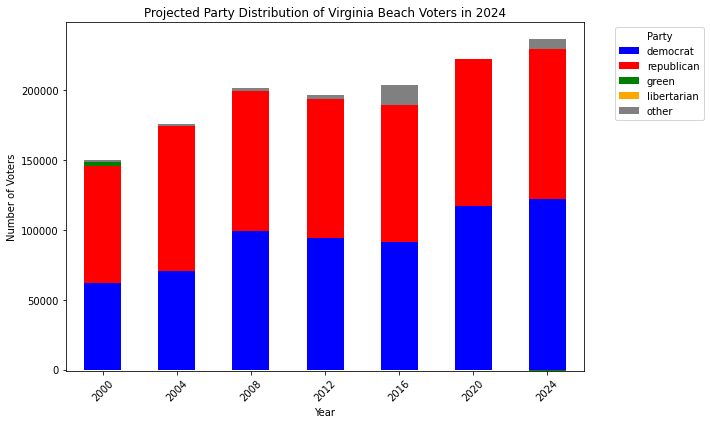

In [37]:
#Predicting 2024 voting outcome for Virginia Beach county
vabeachdf = vb[vb['year'].isin(range(2000, 2024))]

pivot_vdf = vabeachdf.pivot_table(index='year', columns='party', values='candidatevotes', aggfunc='sum', fill_value=0)

column_order = ['democrat', 'republican', 'green', 'libertarian', 'other']
pivot_vdf = pivot_vdf.reindex(columns=column_order)

predictions = {}
for party in pivot_vdf.columns:
    X = pivot_vdf.index.values.reshape(-1, 1)
    y = pivot_vdf[party].values.reshape(-1, 1)

    if np.isnan(y).any():
        print(f"Warning: Missing values detected for party '{party}'. Skipping prediction.")
        continue

    model = LinearRegression()
    model.fit(X, y)
    predictions[party] = model.predict([[2024]])[0][0]

prediction_df = pd.DataFrame(predictions, index=[2024])

pivot_df_with_predictions = pd.concat([pivot_vdf, prediction_df])

pivot_df_with_predictions.plot(kind='bar', stacked=True, color=list(party_colors.values()) + ['pink'], figsize=(10, 6))

plt.title('Projected Party Distribution of Virginia Beach Voters in 2024')
plt.xlabel('Year')
plt.ylabel('Number of Voters')
plt.xticks(rotation=45)
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Virginia Beach was the Virginia county which received the least change in democratic voters. Democratic voters increase from 2000-2008, but decrease between 2008-2016. Democratic votes in Virginia Beach were at an all time high for the 2020 election. For this reason, our statistcal analysis predicts an increase in democratic voters, but little change in republican voters for the 2024 presidential election.

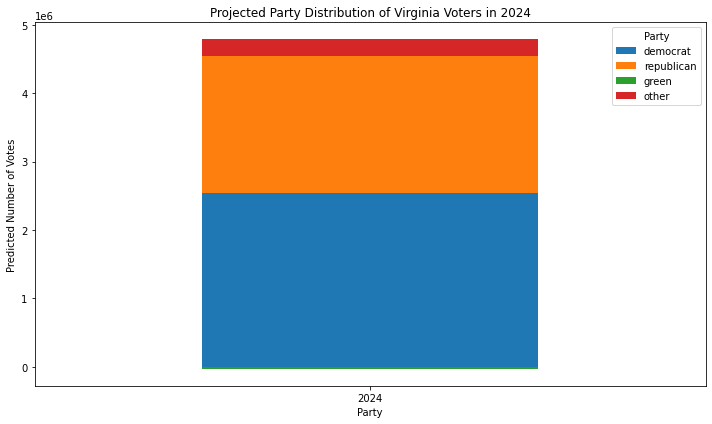

In [38]:
# Assuming vdf_filtered is already prepared and contains the needed data
statewide_df = vdf_filtered[vdf_filtered['year'].isin(range(2000,2020))].groupby(['year', 'party'])['candidatevotes'].sum().unstack(fill_value=0)
column_order = ['democrat', 'republican', 'green', 'libertarian', 'other']
statewide_df = statewide_df.reindex(columns=column_order)

predictions = {}
for party in statewide_df.columns:
    X = statewide_df.index.values.reshape(-1, 1)  # Year
    y = statewide_df[party].values.reshape(-1, 1)  # Votes

    if np.isnan(y).any():
        print(f"Warning: Missing values detected for party '{party}'. Skipping prediction.")
        continue

    model = LinearRegression()
    model.fit(X, y)
    predictions[party] = model.predict([[2024]])[0][0]

# Plot only the predictions for 2024
prediction_df = pd.DataFrame(predictions, index=[2024])
prediction_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Projected Party Distribution of Virginia Voters in 2024')
plt.xlabel('Party')
plt.ylabel('Predicted Number of Votes')
plt.xticks(rotation=0)
plt.legend(title='Party', loc='upper right')
plt.tight_layout()
plt.show()

In [39]:
# Print out predictions as text
total_votes = sum(predictions.values())
print("Predicted Number of Votes for Virginia in 2024 by Party:")
for party, votes in predictions.items():
    print(f"{party.title()}: {int(votes):,} votes ({votes/total_votes:.2%} of total)")

Predicted Number of Votes for Virginia in 2024 by Party:
Democrat: 2,535,669 votes (53.28% of total)
Republican: 2,002,439 votes (42.07% of total)
Green: -35,623 votes (-0.75% of total)
Other: 257,068 votes (5.40% of total)


We predicted the party distribution of voters in the 2024 election for three Virginia counties: Fairfax, Virginia Beach, and Albemarle. This visual shows the total predicted votes from each county, which gives us a prediction as to how Virginia may lean in the upcoming election. About half of the voters are projected to be democrats (51%), with republicans (45%) and green/other parties making up the other half of voters.

## Conclusion

This project aims to predict the election results in Virginia for 2024, utilizing historical voting data from 2000 to 2020 to analyze trends and make informed projections. We focused on key variables such as 'year,' 'county name,' 'candidate,' 'party,' 'candidate votes,' and 'total votes,' which are crucial for gaining  valuable insights. The analysis revealed a significant shift in Virginia's voter distribution, increasingly favoring the Democratic Party since the 2000 election. This trend, particularly noticeable after the 2008 election, indicated a pivot from predominantly Republican to Democratic votes. Based on these patterns, we predict that Virginia will lean Democratic in the upcoming 2024 election, likely featuring a rematch between Joe Biden and Donald Trump. Our statistical models suggest a higher likelihood of Virginia voters supporting Joe Biden, potentially designating the state as "blue" and contributing 13 electoral votes towards his national tally.

The analysis at the county level identified Fairfax in Northern Virginia as having the highest rate of increase in Democratic voters, whereas Virginia Beach in the southeastern coastal region showed the lowest. This geographical variance highlights the strategic importance of localized campaigning, especially in swing states like Virginia, where significant efforts could tip the balance in either direction.Given the historical data and current trends, our recommendation for the Biden campaign is to focus on Southern Virginia, particularly around areas like Virginia Beach, which show a slower rate of Democratic growth. Targeting these regions could maximize campaign impact, possibly swaying the overall state results.

In regards to potential criticism or questions of how reputable our project is, we can defend our project with the evidence of our comprehensive data set and usage of a variety of statistical models for our analysis. We've chosen relevant variables for predicting election outcomes and employed both trend analysis and predictive modeling, cross-validating our findings for reliability. We are transparent about the assumptions of our models and provide cautious interpretations of our results. We do acknowledge that there is much work that could be done that is outside of the scope of the project. Analyzing the impacts of social media platforms could significantly enhance the predictive power of your project by gathering data of opinion trends. This approach involves scanning and interpreting the vast amounts of data generated by users on platforms. Doing so could provide strategic advantages in creating campaign messages and strategies. 

In conclusion, our project predicts a continued rise in Democratic support among Virginia voters, potentially influencing the state's political alignment in the 2024 presidential election. These projections will be testable against actual voting outcomes in November 2024. 